## ME447 Project 1
#### Amanda Schultz (amanda36) and Avanthi Obadage (obadage2)

### 2. 1/0 Knapsack Probelm 
#### Genetic Algorithm version

In [177]:
import numpy as np
import matplotlib.pyplot as plt

A_data = np.load("A.npz") # dict format: n_items, capacity, item_values, item_weights
B_data = np.load("B.npz")

n_items  = int(A_data["n_items"])
capacity = int(A_data["capacity"])
values   = np.array(A_data["item_values"])
weights  = np.array(A_data["item_weights"])

# Representation
def initialize_population(pop_size, n_items):
    """some inital population binary solutions """
    return np.random.randint(2, size=(pop_size, n_items))

# Fitness 
def fitness(individual, values, weights, capacity):
    """
    Return total value if under or at capacity, otherwise penalize proportional to how much the capacity is exceeded.
    """
    total_weight = np.sum(individual * weights)
    total_value  = np.sum(individual * values)

    if total_weight <= capacity:
        return total_value
    else:
        penalty = (total_weight - capacity) * np.mean(values)
        return total_value - penalty

# Deterministic Parent Selection
def select_parents(population, num_parents, values, weights, capacity):
    """Select top individual solutions (parents)"""
    fitness_vals = np.array([fitness(ind, values, weights, capacity) for ind in population])
    sorted_idx = np.argsort(fitness_vals)[-num_parents:]
    return population[sorted_idx]

# Recombination (crossover)
def crossover(parents, offspring_size):
    """crosses best fit parents to create new generation"""
    n_items = parents.shape[1]
    offspring = []
    while len(offspring) < offspring_size:
        for i in range(len(parents) // 2):
            p1 = parents[i]
            p2 = parents[-(i+1)]
            point = np.random.randint(1, n_items)
            c1 = np.concatenate([p1[:point], p2[point:]])
            c2 = np.concatenate([p2[:point], p1[point:]])
            offspring.append(c1)
            if len(offspring) < offspring_size:
                offspring.append(c2)
    return np.array(offspring[:offspring_size])

# Mutation
def mutate(offspring, mutation_prob=0.05):
    """Randomly mutate offspring by bit-flipping"""
    mutation = np.random.rand(*offspring.shape) < mutation_prob
    return np.logical_xor(offspring, mutation).astype(int)

# Environmental Selection
def environmental_selection(offspring, pop_size, values, weights, capacity):
    """Select best fit offspring for next generation"""
    fitness_vals = np.array([fitness(ind, values, weights, capacity) for ind in offspring])
    top_idx = np.argsort(fitness_vals)[-pop_size:]
    return offspring[top_idx]

# Run simulation!
def run_ga_knapsack(n_items, capacity, values, weights,
                    pop_size=500, generations=100,
                    mutation_prob=0.05):
    population = initialize_population(pop_size, n_items)
    num_parents = pop_size // 2
    track_fitness_gen = np.empty(generations)
    for gen in range(generations):
        parents = select_parents(population, num_parents, values, weights, capacity)
        offspring = crossover(parents, pop_size * 2)   # oversample
        offspring = mutate(offspring, mutation_prob)
        population = environmental_selection(offspring, pop_size, values, weights, capacity)
        

        fitness_vals = np.array([fitness(ind, values, weights, capacity) for ind in population])
        best_idx = np.argmax(fitness_vals)
        best_solution = population[best_idx]
        best_value = fitness_vals[best_idx]
        track_fitness_gen[gen] = best_value

    # Best solution
    fitness_vals = np.array([fitness(ind, values, weights, capacity) for ind in population])
    best_idx = np.argmax(fitness_vals)
    best_solution = population[best_idx]
    best_value = fitness_vals[best_idx]
    
    return best_solution, best_value, track_fitness_gen

# ==============================
# Example Run
# ==============================
population_size = 500
num_gen = 100
best_solution, best_value, peak_fitness_100 = run_ga_knapsack(n_items, capacity, values, weights, pop_size = 100, generations=num_gen)

print("Best solution:", best_solution)
print("Total value:", best_value)


Best solution: [1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0]
Total value: 66.0


### CMA-ES Version

Best solution (binary vector): [1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1
 1 1 1 0 1 0 0 0 1 0 1 1 1]
Best total value: 309.0


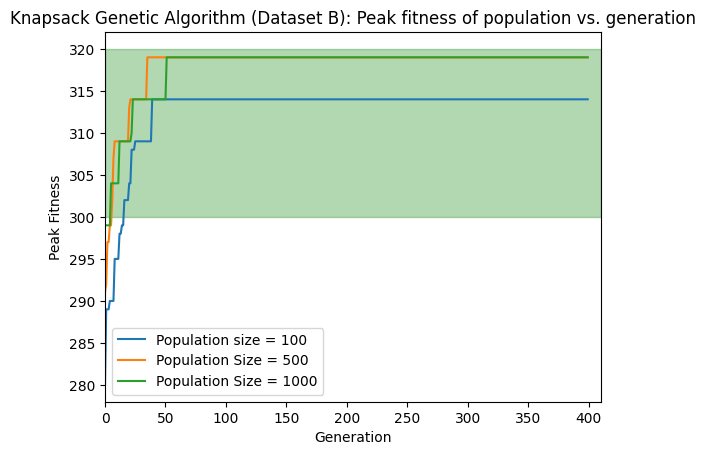

In [ ]:
A_data = np.load("A.npz") # dict format: n_items, capacity, item_values, item_weights
B_data = np.load("B.npz")

n_items  = int(B_data["n_items"])
capacity = int(B_data["capacity"])
values   = np.array(B_data["item_values"])
weights  = np.array(B_data["item_weights"])
class CMAES:
    def __init__(self, n_items, capacity, values, weights, 
                 pop_size=None, mu=None, sigma=0.5, max_iter=200):
        """
        CMA-ES for 0/1 Knapsack Problem
        n_items   : number of items
        capacity  : max weight of knapsack
        values    : item values 
        weights   : item weights 
        pop_size  : number of offspring 
        mu        : number of parents 
        sigma     : initial step size
        max_iter  : number of iterations
        """
        self.n = len(values)
        self.capacity = float(capacity)
        self.values = np.array(values)
        self.item_weights = np.array(weights)

        self.lam = pop_size if pop_size else 4 + int(3 * np.log(n_items))
        self.mu = mu if mu else self.lam // 2
        self.sigma = sigma
        self.max_iter = max_iter

        # initial mean vector
        self.mean = np.ones(self.n) * 0.5

        # weights for recombination
        w = np.log(self.mu + 0.5) - np.log(np.arange(1, self.mu+1))
        self.rec_weights = w / np.sum(w)
        self.mueff = np.sum(self.rec_weights)**2 / np.sum(self.rec_weights**2)

        # covariance matrix
        self.C = np.identity(self.n)

        # evolution paths
        self.pc = np.zeros(self.n)
        self.ps = np.zeros(self.n)

        # step size control
        self.cc = (4 + self.mueff/self.n) / (self.n+4 + 2*self.mueff/self.n)
        self.cs = (self.mueff + 2) / (self.n + self.mueff + 5)
        self.c1 = 2 / ((self.n+1.3)**2 + self.mueff)
        self.cmu = min(1 - self.c1, 2*(self.mueff-2+1/self.mueff)/((self.n+2)**2+self.mueff))
        self.damps = 1 + 2*max(0, np.sqrt((self.mueff-1)/(self.n+1))-1) + self.cs

        self.B = np.identity(self.n)
        self.D = np.ones(self.n)
        self.inv_sqrt_C = np.identity(self.n)

        self.chiN = np.sqrt(self.n) * (1 - 1/(4*self.n) + 1/(21*self.n**2))

        # logging
        self.history = []

    def fitness(self, x_bin):
        total_value = np.dot(self.values, x_bin)
        total_weight = np.dot(self.item_weights, x_bin)
        penalty_factor = 10   # <-- increase from 10 to 50 or 100
        if total_weight > self.capacity:
            return total_value - penalty_factor * (total_weight - self.capacity)
        return total_value


    def ask(self):
        """Sample new population from multivariate normal"""
        arz = np.random.randn(self.n, self.lam)
        ary = self.B @ (self.D.reshape(-1,1) * arz)
        arx = self.mean.reshape(-1,1) + self.sigma * ary
        return arx.T, arz.T

    def binarize(self, x):
        """Map continuous vector to binary vector"""
        return (x > 0.5).astype(int)

    def run(self):
        best_val = -np.inf
        best_x = None

        for gen in range(self.max_iter):
            # sample candidates
            arx, arz = self.ask()

            # evaluate fitness on binarized solutions
            fits = np.array([self.fitness(self.binarize(x)) for x in arx])

            # sort by fitness
            idx = np.argsort(-fits)  # maximize
            arx = arx[idx]
            arz = arz[idx]
            fits = fits[idx]

            # update best
            if fits[0] > best_val:
                best_val = fits[0]
                best_x = self.binarize(arx[0])

            # recombination
            xold = self.mean
            self.mean = np.dot(self.rec_weights, arx[:self.mu])

            # update evolution paths
            y = np.dot(self.rec_weights, arz[:self.mu])
            self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs*(2-self.cs)*self.mueff) * (self.B @ y)
            hsig = int((np.linalg.norm(self.ps)/np.sqrt(1-(1-self.cs)**(2*(gen+1)))/self.chiN) < (1.4+2/(self.n+1)))
            self.pc = (1 - self.cc)*self.pc + hsig*np.sqrt(self.cc*(2-self.cc)*self.mueff)*(self.B @ (self.D*y))

            # covariance update
            artmp = (1/self.sigma) * (arx[:self.mu] - xold)
            self.C = (1 - self.c1 - self.cmu)*self.C \
                     + self.c1*(np.outer(self.pc, self.pc) + (1-hsig)*self.cc*(2-self.cc)*self.C) \
                     + self.cmu * np.sum([w*np.outer(ar,ar) for w,ar in zip(self.rec_weights, artmp)], axis=0)

            # step size
            self.sigma *= np.exp((self.cs/self.damps)*(np.linalg.norm(self.ps)/self.chiN - 1))

            # eigendecomposition
            if gen % (self.n//10+1) == 0:
                self.D, self.B = np.linalg.eigh(self.C)
                self.D = np.sqrt(np.maximum(self.D, 1e-20))
                self.inv_sqrt_C = self.B @ np.diag(self.D**-1) @ self.B.T

            # log history
            self.history.append(best_val)

        return best_x, best_val, self.history

# run
cma_knap = CMAES(n_items, capacity, values, weights, max_iter=700)

best_sol, best_val, hist = cma_knap.run()

print("Best solution (binary vector):", best_sol)
print("Best total value:", best_val)

### CMA-ES for continuous functions

In [155]:
import numpy as np

class CMAES:
    def __init__(self, n_dim, problem='parabola',
                 pop_size=None, mu=None, sigma=None, max_iter=500):
        """
        CMA for continuous minimization problems.
        Supports: 'parabola', 'ellipsoid', 'rastrigin'
        """
        self.n = int(n_dim)
        self.problem = problem

        # CMA-ES parameters
        self.lam = pop_size if pop_size else 4 + int(3 * np.log(self.n + 1))
        self.mu = mu if mu else self.lam // 2
        self.sigma = sigma if sigma else 0.2
        self.max_iter = max_iter

        # recombination weights
        w = np.log(self.mu + 0.5) - np.log(np.arange(1, self.mu + 1))
        self.weights = w / np.sum(w)
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)

        # initialization
        self.mean = np.zeros(self.n)
        self.C = np.identity(self.n)
        self.pc = np.zeros(self.n)
        self.ps = np.zeros(self.n)

        # constants
        self.cc = (4 + self.mueff/self.n) / (self.n + 4 + 2*self.mueff/self.n)
        self.cs = (self.mueff + 2) / (self.n + self.mueff + 5)
        self.c1 = 2 / ((self.n + 1.3)**2 + self.mueff)
        self.cmu = min(1 - self.c1,
                       2*(self.mueff - 2 + 1/self.mueff) /
                       ((self.n + 2)**2 + self.mueff))
        self.damps = 1 + 2*max(0, np.sqrt((self.mueff-1)/(self.n+1)) - 1) + self.cs

        # eigen decomposition
        self.B = np.identity(self.n)
        self.D = np.ones(self.n)
        self.inv_sqrt_C = np.identity(self.n)
        self.chiN = np.sqrt(self.n) * (1 - 1/(4*self.n) + 1/(21*self.n**2))

        self.history = []

    # Objective functions
    def fitness(self, x):
        """Return f(x) for the current problem (minimization)."""
        if self.problem == 'parabola':
            return 10 * np.sum(x**2)

        elif self.problem == 'ellipsoid':
            # Rotated hyper-ellipsoid
            x1, x2 = x[0], x[1]
            term1 = (np.sqrt(3)/2*(x1 - 3) + 0.5*(x2 - 5))**2
            term2 = 5*((np.sqrt(3)/2*(x2 - 5) - 0.5*(x1 - 3)))**2
            return term1 + term2

        elif self.problem == 'rastrigin':
            d = len(x)
            return 10*d + np.sum((x - 2)**2 - 10*np.cos(2*np.pi*(x - 2)))

        else:
            raise ValueError(f"Unknown problem '{self.problem}'")


    # Core CMA logic
    def ask(self):
        """Generate new candidate population."""
        arz = np.random.randn(self.n, self.lam)
        ary = self.B @ (self.D.reshape(-1, 1) * arz)
        arx = self.mean.reshape(-1, 1) + self.sigma * ary
        return arx.T, arz.T

    def run(self):
        best_val = np.inf
        best_x = None

        for gen in range(self.max_iter):
            arx, arz = self.ask()
            fits = np.array([self.fitness(x) for x in arx])
            idx = np.argsort(fits)
            arx, arz, fits = arx[idx], arz[idx], fits[idx]

            if fits[0] < best_val:
                best_val = fits[0]
                best_x = arx[0]

            xold = self.mean
            self.mean = np.dot(self.weights, arx[:self.mu])
            y = np.dot(self.weights, arz[:self.mu])

            # evolution paths
            self.ps = (1 - self.cs)*self.ps + np.sqrt(self.cs*(2-self.cs)*self.mueff)*(self.B @ y)
            hsig = int(
                (np.linalg.norm(self.ps)/np.sqrt(1-(1-self.cs)**(2*(gen+1)))/self.chiN)
                < (1.4 + 2/(self.n+1))
            )
            self.pc = (1 - self.cc)*self.pc + hsig*np.sqrt(self.cc*(2-self.cc)*self.mueff)*(self.B @ (self.D*y))

            # covariance update
            artmp = (1/self.sigma)*(arx[:self.mu] - xold)
            self.C = (1 - self.c1 - self.cmu)*self.C \
                     + self.c1*(np.outer(self.pc, self.pc) + (1-hsig)*self.cc*(2-self.cc)*self.C) \
                     + self.cmu*np.sum([w*np.outer(ar, ar)
                                        for w, ar in zip(self.weights, artmp)], axis=0)

            # step size
            self.sigma *= np.exp((self.cs/self.damps)*(np.linalg.norm(self.ps)/self.chiN - 1))

            # decomposition update
            if gen % (self.n//10 + 1) == 0:
                self.D, self.B = np.linalg.eigh(self.C)
                self.D = np.sqrt(np.maximum(self.D, 1e-20))
                self.inv_sqrt_C = self.B @ np.diag(self.D**-1) @ self.B.T

            self.history.append(best_val)

            # stop once essentially converged
            if best_val < 1e-40:
                break

        return best_x, best_val, self.history

### 3. Minima of the Parabola
#### Genetic Algorithm version

In [172]:
#Initialization
import numpy as np
from math import comb
SEED = 42
rng = np.random.default_rng(seed=SEED)
import matplotlib.pyplot as plt

In [173]:
#Representation
pop_size = 100
num_parents = pop_size//2
num_offspring = comb(num_parents, 2)//2

def parabola_problem(individual):
    return 10*individual**2

In [174]:
#Calculate Fitness
def fitness(pop):
    return np.array([parabola_problem(element) for element in pop])

#Select Parents
def select_parents(pop, num_par):
    pop_fitness = fitness(pop)
    sorted_ind = np.argsort(pop_fitness)
    chosen_ind = sorted_ind[0:num_par]
    chosen_parents = pop[chosen_ind]
    return chosen_parents

#Crossover to generate offspring, taking the average between two randomly selected parents from the set
def crossover(parents, num_parents, num_offspring):
    offspring = np.empty(num_offspring)
    for n in range(num_offspring):
        parent1_idx, parent2_idx = rng.choice(np.arange(num_parents), size = 2, replace = True)
        offspring[n] = (parents[parent1_idx] + parents[parent2_idx])/2
    return offspring

#Mutate offspring, using uniformly generated random numbers between -0.5 and 0.5
def mutate(offspring, prob):
    mutated_offspring = offspring.copy()

    mask = rng.uniform(size=offspring.shape)<prob
    drawn_numbers =  rng.uniform(-0.5, 0.5, size = offspring.shape)

    mutated_offspring[mask] = drawn_numbers[mask]

    return mutated_offspring

#Environmental selection, choose the fittest offspring to be the next generation
def environmental_selection(offspring):
    fitness_vals = fitness(offspring)
    sorted_ind = np.argsort(fitness_vals)
    chosen_ind = sorted_ind[0:pop_size]
    chosen_offspring = offspring[chosen_ind]
    return chosen_offspring

#run the algorithm
def run_ga_parabola(pop_size = 100, generations = 20, mutation_prob = 0.005):
    num_parents = pop_size//2
    num_offspring = comb(num_parents, 2)//2
    population = rng.uniform(-40,40, size = pop_size)
    track_fitness_gen = np.empty(generations)

    for gen in range(generations):
        parents = select_parents(population, num_parents)
        offspring = crossover(parents, num_parents, num_offspring)
        #print(offspring)
        mutated_offspring = mutate(offspring, mutation_prob)
        #print(mutated_offspring)
        population = environmental_selection(mutated_offspring)
        pop_fitness = fitness(population)
        best_idx = np.argmax(pop_fitness)
        track_fitness_gen[gen] = pop_fitness[best_idx]

    pop_fitness = fitness(population)
    best_idx = np.argmax(pop_fitness)
    best_solution = population[best_idx]
    best_value = pop_fitness[best_idx]
    return best_solution, best_value, track_fitness_gen

In [176]:
#Algorithm output for a population size of 50, with 50 generations
best_sol, best_val, parabola_fitness_pop50 = run_ga_parabola(pop_size=50, generations = 50)
print(best_sol, best_val)

parabola_cma = CMAES(n_dim = 1)
best_sol, best_val, parabola_fitness_cma = parabola_cma.run() 
print(best_sol, best_val)

4.5579131874133594e-08 2.077457262399661e-14
[-5.0706368e-22] 2.5711357525127245e-42


### 4. Hyperellipsoid Optimization
#### Genetic Algorithm version

In [161]:
#Initialization
import numpy as np
from math import comb
SEED = 42
rng = np.random.default_rng(seed=SEED)

In [162]:
#Representation
pop_size = 100
num_parents = pop_size//2
num_offspring = comb(num_parents, 2)//2

def hyperellipsoid_problem(individual):
    f_x = (np.sqrt(3)/2 * (individual[0] - 3) + 0.5 * (individual[1] - 5))**2 + \
        5 * (np.sqrt(3)/2 * (individual[1] - 5) - 0.5 * (individual[0] - 3))**2
    return f_x

In [163]:
#Calculate Fitness
def fitness(pop):
    return [hyperellipsoid_problem(element) for element in pop]

#Select Parents
def select_parents(pop, num_par):
    pop_fitness = fitness(pop)
    sorted_ind = np.argsort(pop_fitness)
    chosen_ind = sorted_ind[0:num_par]
    chosen_parents = pop[chosen_ind]
    return chosen_parents

#Crossover to generate offspring, taking the average between two randomly selected parents from the set
def crossover(parents, num_parents, num_offspring, crossover_method):
    offspring = np.empty((num_offspring,2))
    for n in range(num_offspring):
        parent1_idx, parent2_idx = rng.choice(np.arange(num_parents), size = 2, replace = True)
        parent1 = parents[parent1_idx]
        parent2 = parents[parent2_idx]
        if(crossover_method == "average"):
            offspring[n] = (parent1+parent2)/2
        elif (crossover_method == "half/half"):
            offspring[n] = np.array((parent1[0], parent2[1]))
    return offspring

#Mutate offspring by shifting the mutated offspring values by some delta within [-0.5,0.5) with some prob
def mutate(offspring, prob):
    mutated_offspring = offspring.copy()

    mask = rng.uniform(size=offspring.shape)<prob
    drawn_numbers =  rng.uniform(-0.5, 0.5, size = offspring.shape)
    mutated_offspring[mask] = offspring[mask]+drawn_numbers[mask]

    return mutated_offspring

#Environmental selection, choose the fittest offspring to be the next generation
def environmental_selection(offspring):
    fitness_vals = fitness(offspring)
    sorted_ind = np.argsort(fitness_vals)
    chosen_ind = sorted_ind[0:pop_size]
    chosen_offspring = offspring[chosen_ind]
    return chosen_offspring

def run_ga_hyperellipsoid(pop_size = 100, generations = 100, crossover_method = "average", mutation_prob = 0.005):
    population = rng.uniform(-10,10, size = (pop_size, 2))
    num_parents = pop_size//2
    num_offspring = comb(num_parents, 2)//2

    track_fitness_gen = np.empty(generations)
    
    for gen in range(generations):
        parents = select_parents(population, num_parents)
        offspring = crossover(parents, num_parents, num_offspring, crossover_method)
        #print(offspring)
        mutated_offspring = mutate(offspring, mutation_prob)
        #print(mutated_offspring)
        population = environmental_selection(mutated_offspring)
        pop_fitness = fitness(population)
        best_ind = np.argmin(pop_fitness)
        track_fitness_gen[gen] = pop_fitness[best_ind]

    pop_fitness = fitness(population)
    best_idx = np.argmin(pop_fitness)
    best_solution = population[best_idx]
    best_value = pop_fitness[best_idx]

    return best_solution, best_value, track_fitness_gen

In [ ]:
#Find the output for population size 100, 100 generations
best_sol, best_val, hyper_fitness_pop100 = run_ga_hyperellipsoid(pop_size = 100, generations = 100, crossover_method = "average")
print(best_val)

1.6574184672478297e-10


### Run CMA-ES for hyperellipsoid and plot results

148.044


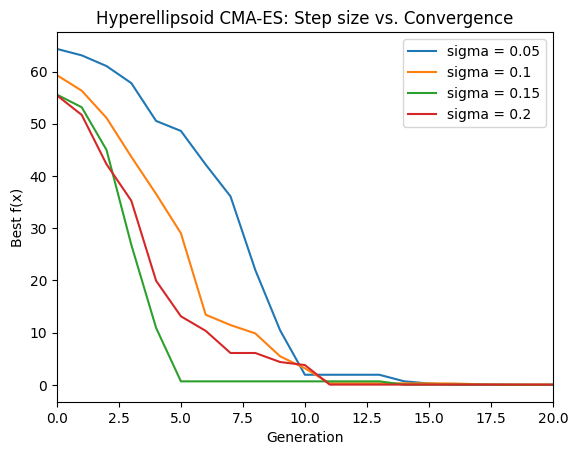

In [166]:
#Run CMA for hyperellipsoid with various step sizes
hyperellipsoid_sigmapoint05 = CMAES(n_dim = 2, problem = "ellipsoid", sigma = 0.05)
hyperellipsoid_sigmapoint10 = CMAES(n_dim = 2, problem = "ellipsoid", sigma = 0.1)
hyperellipsoid_sigmapoint15 = CMAES(n_dim = 2, problem = "ellipsoid", sigma = 0.15)
hyperellipsoid_sigmapoint20 = CMAES(n_dim = 2, problem = "ellipsoid", sigma = 0.20)
best_sol, best_val, hyperellipsoid_fitness_point05 = hyperellipsoid_sigmapoint05.run()
best_sol, best_val, hyperellipsoid_fitness_point10 = hyperellipsoid_sigmapoint10.run()
best_sol, best_val, hyperellipsoid_fitness_point15 = hyperellipsoid_sigmapoint15.run()
best_sol, best_val, hyperellipsoid_fitness_point20 = hyperellipsoid_sigmapoint20.run()

#Create x-coordinates (generations) for plotting
x_point05 = range(np.size(hyperellipsoid_fitness_point05))
x_point10 = range(np.size(hyperellipsoid_fitness_point10))
x_point15 = range(np.size(hyperellipsoid_fitness_point15))
x_point20 = range(np.size(hyperellipsoid_fitness_point20))

#Plot CMA results for step size variation
plt.plot(x_point05, hyperellipsoid_fitness_point05, label = "sigma = 0.05")
plt.plot(x_point10, hyperellipsoid_fitness_point10, label = "sigma = 0.1")
plt.plot(x_point15, hyperellipsoid_fitness_point15, label = "sigma = 0.15")
plt.plot(x_point20, hyperellipsoid_fitness_point20, label = "sigma = 0.2")
plt.xlim(0,20)
plt.xlabel("Generation")
plt.ylabel("Best f(x)")
plt.title("Hyperellipsoid CMA-ES: Step size vs. Convergence")
plt.legend()


#Run cma for step size 0.2 to find average number of generations to converge
avg_num_gen = 0

for n in range(0,500):
    hyperellipsoid_sigmapoint20 = CMAES(n_dim = 2, pop_size = 100, problem = "ellipsoid", sigma = 0.20)
    best_sol, best_val, hyperellipsoid_fitness_point05 = hyperellipsoid_sigmapoint05.run()
    best_sol, best_val, hyperellipsoid_fitness_point10 = hyperellipsoid_sigmapoint10.run()
    best_sol, best_val, hyperellipsoid_fitness_point15 = hyperellipsoid_sigmapoint15.run()
    best_sol, best_val, hyperellipsoid_fitness_point20 = hyperellipsoid_sigmapoint20.run()
    avg_num_gen += np.size(hyperellipsoid_fitness_point20)
 

print(avg_num_gen/500)
